In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, roc_auc_score,log_loss,brier_score_loss
from sklearn.metrics import roc_curve, auc

/tmp/ipykernel_554942/3028590550.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
features_all = pd.read_csv("data/features_2022_2023_final.csv")

In [4]:
features_all.columns

Index(['id', 'match_id', 'team_id', 'possession_team_id', 'player_id',
       'passer_name', 'pass_recipient_id', 'receiver_name', 'team_name',
       'start_x', 'start_y', 'end_x', 'end_y', 'passer_x', 'passer_y',
       'start_distance_to_goal', 'end_distance_to_goal', 'pass_length',
       'pass_angle', 'start_angle_to_goal', 'end_angle_to_goal',
       'start_distance_to_sideline', 'end_distance_to_sideline',
       'forward pass', 'backward pass', 'lateral pass', 'teammates_behind',
       'teammates_beyond', 'opponents_beyond', 'opponents_behind',
       'opponents_between', 'packing', 'pressure_on_passer',
       'average_speed_of_teammates', 'average_speed_of_opponents',
       'opponents_nearby', 'pressure level passer', 'teammates_nearby',
       'possession_xg', 'possession_goal', 'possession_xG_target', 'season',
       'speed_difference', 'h1', 'h2', 'h3', 'h4'],
      dtype='object')

In [5]:
features_all = features_all [['id','start_distance_to_goal', 'end_distance_to_goal', 'pass_length',
       'pass_angle', 'start_angle_to_goal', 'end_angle_to_goal',
       'start_distance_to_sideline', 'end_distance_to_sideline','teammates_behind',
       'teammates_beyond', 'opponents_beyond', 'opponents_behind',
       'opponents_between', 'packing', 'pressure_on_passer',
       'average_speed_of_teammates', 'average_speed_of_opponents',
       'opponents_nearby','teammates_nearby','possession_xG_target']]

In [6]:
features_train = features_all[['possession_xG_target', 'start_distance_to_goal',
       'end_distance_to_goal', 'pass_length', 'pass_angle','start_angle_to_goal','end_angle_to_goal',
       'start_distance_to_sideline', 'end_distance_to_sideline','teammates_behind',
       'teammates_beyond','opponents_beyond','opponents_behind','opponents_between','packing','pressure_on_passer','average_speed_of_teammates',
       'average_speed_of_opponents', 'opponents_nearby', 'teammates_nearby']]


### pressure based model

In [7]:
X_1 = features_train[['packing','pressure_on_passer','teammates_nearby','opponents_nearby']]

Y_1 = features_train[['possession_xG_target']]

X_train_1,X_test_1,Y_train_1,Y_test_1 = train_test_split(X_1,Y_1,test_size=0.25,random_state=50)

logit_formula_1 = "possession_xG_target ~ packing + pressure_on_passer + teammates_nearby + opponents_nearby"

train_data_1 = X_train_1.copy()
train_data_1['possession_xG_target'] = Y_train_1

model_roc_1 = smf.logit(logit_formula_1, data=train_data_1).fit(method='bfgs', maxiter=200)

model_roc_1.summary()

Optimization terminated successfully.
         Current function value: 0.373694
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     possession_xG_target   No. Observations:                55565
Model:                            Logit   Df Residuals:                    55560
Method:                             MLE   Df Model:                            4
Date:                  Sun, 18 May 2025   Pseudo R-squ.:                0.003091
Time:                          18:30:41   Log-Likelihood:                -20764.
converged:                         True   LL-Null:                       -20829.
Covariance Type:              nonrobust   LLR p-value:                 7.111e-27
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.1967      0.026    -83.863      0.000      -2.248      -2.145
packing                0.0468      0.008      5.775      0.000       0.031       0.063
pressure_on_passer     0.0915      0.052      1.762      0.078      -0.010       0.193
teammates_nearby      -0.0370      0.027     -1.367      0.172      -0.090       0.016
opponents_nearby       0.0863      0.024      3.671      0.000       0.040       0.132
======================================================================================
"""

In [8]:
test_data_1 = X_test_1.copy()
test_data_1['possession_xG_target'] = Y_test_1
y_pred_prob_1 = model_roc_1.predict(test_data_1)
fpr, tpr, thresholds = roc_curve(Y_test_1,y_pred_prob_1)
roc_auc_1 = auc(fpr, tpr)
roc_auc_1 = roc_auc_score(Y_test_1, y_pred_prob_1)
brier_1  = brier_score_loss(Y_test_1, y_pred_prob_1)
logloss_1 = log_loss(Y_test_1, y_pred_prob_1)
print(f"ROC AUC :      {roc_auc_1:.4f}")
print(f"Logloss:{logloss_1:.4f}")
print(f"Brier Score:  {brier_1:.4f}")


ROC AUC :      0.5428
Logloss:0.3782
Brier Score:  0.1101


### speed based model

In [9]:
X_2 = features_train[['average_speed_of_teammates',
       'average_speed_of_opponents']]

Y_2 = features_train[['possession_xG_target']]

X_train_2,X_test_2,Y_train_2,Y_test_2 = train_test_split(X_2,Y_2,test_size=0.25,random_state=50)

logit_formula_2 = "possession_xG_target ~ average_speed_of_teammates + average_speed_of_opponents"

train_data_2 = X_train_2.copy()
train_data_2['possession_xG_target'] = Y_train_2

model_roc_2 = smf.logit(logit_formula_2, data=train_data_2).fit(method='bfgs', maxiter=200)

model_roc_2.summary()


Optimization terminated successfully.
         Current function value: 0.370745
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     possession_xG_target   No. Observations:                55565
Model:                            Logit   Df Residuals:                    55562
Method:                             MLE   Df Model:                            2
Date:                  Sun, 18 May 2025   Pseudo R-squ.:                 0.01096
Time:                          18:30:48   Log-Likelihood:                -20600.
converged:                         True   LL-Null:                       -20829.
Covariance Type:              nonrobust   LLR p-value:                7.287e-100
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.6607      0.036    -73.876      0.000      -2.731      -2.590
average_speed_of_teammates     0.1567      0.033      4.819      0.000       0.093       0.220
average_speed_of_opponents     0.1277      0.030      4.232      0.000       0.069       0.187
==============================================================================================
"""

In [10]:
test_data_2 = X_test_2.copy()
test_data_2['possession_xG_target'] = Y_test_2
y_pred_prob_2 = model_roc_2.predict(test_data_2)
fpr, tpr, thresholds = roc_curve(Y_test_2,y_pred_prob_2)
roc_auc_2 = auc(fpr, tpr)
brier_2  = brier_score_loss(Y_test_2, y_pred_prob_2)
logloss_2 = log_loss(Y_test_2, y_pred_prob_2)
print(f"ROC AUC:      {roc_auc_2:.4f}")
print(f"Logloss:{logloss_2:.4f}")
print(f"Brier Score:  {brier_2:.4f}")

ROC AUC:      0.5685
Logloss:0.3752
Brier Score:  0.1094


### position based features

In [11]:
X_3 = features_train[['teammates_behind',
       'teammates_beyond', 'opponents_beyond', 'opponents_behind',
       'opponents_between']]

Y_3 = features_train[['possession_xG_target']]

X_train_3,X_test_3,Y_train_3,Y_test_3 = train_test_split(X_3,Y_3,test_size=0.25,random_state=50)

logit_formula_3 = "possession_xG_target ~ teammates_behind + teammates_beyond + opponents_beyond + opponents_behind + opponents_between"

train_data_3 = X_train_3.copy()
train_data_3['possession_xG_target'] = Y_train_3

model_roc_3 = smf.logit(logit_formula_3, data=train_data_3).fit(method='bfgs', maxiter=200)

model_roc_3.summary()


Optimization terminated successfully.
         Current function value: 0.367221
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     possession_xG_target   No. Observations:                55565
Model:                            Logit   Df Residuals:                    55559
Method:                             MLE   Df Model:                            5
Date:                  Sun, 18 May 2025   Pseudo R-squ.:                 0.02036
Time:                          18:30:53   Log-Likelihood:                -20405.
converged:                         True   LL-Null:                       -20829.
Covariance Type:              nonrobust   LLR p-value:                4.532e-181
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.7604      0.536      3.284      0.001       0.710       2.811
teammates_behind      0.0555      0.027      2.083      0.037       0.003       0.108
teammates_beyond     -0.0214      0.027     -0.786      0.432      -0.075       0.032
opponents_beyond     -0.4132      0.041     -9.959      0.000      -0.495      -0.332
opponents_behind     -0.3198      0.041     -7.707      0.000      -0.401      -0.238
opponents_between     0.0480      0.006      8.703      0.000       0.037       0.059
=====================================================================================
"""

In [12]:
from sklearn.metrics import roc_curve, auc

test_data_3 = X_test_3.copy()
test_data_3['possession_xG_target'] = Y_test_3
y_pred_prob_3 = model_roc_3.predict(test_data_3)
fpr, tpr, thresholds = roc_curve(Y_test_3,y_pred_prob_3)
roc_auc_3 = auc(fpr, tpr)
brier_3  = brier_score_loss(Y_test_3, y_pred_prob_3)
logloss_3 = log_loss(Y_test_3, y_pred_prob_3)
print(f"ROC AUC:      {roc_auc_3:.4f}")
print(f"Logloss:{logloss_3:.4f}")
print(f"Brier Score:  {brier_3:.4f}")


ROC AUC:      0.6136
Logloss:0.3701
Brier Score:  0.1081


### event based model

In [13]:
X_4 = features_all[['start_distance_to_goal',
       'end_distance_to_goal', 'pass_length', 'pass_angle','start_angle_to_goal','end_angle_to_goal',
       'start_distance_to_sideline', 'end_distance_to_sideline']]
Y_4 = features_all[["possession_xG_target"]]

X_train_4,X_test_4,Y_train_4,Y_test_4 = train_test_split(X_4,Y_4,test_size=0.25,random_state=50)

logit_formula_4 = "possession_xG_target ~ start_distance_to_goal + end_distance_to_goal + pass_length + pass_angle + start_angle_to_goal + end_angle_to_goal + start_distance_to_sideline + end_distance_to_sideline"

train_data_4 = X_train_4.copy()
train_data_4['possession_xG_target'] = Y_train_4

model_roc_4 = smf.logit(logit_formula_4, data=train_data_4).fit(method='bfgs', maxiter=200)
model_roc_4.summary()

Optimization terminated successfully.
         Current function value: 0.358550
         Iterations: 42
         Function evaluations: 49
         Gradient evaluations: 49


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     possession_xG_target   No. Observations:                55565
Model:                            Logit   Df Residuals:                    55556
Method:                             MLE   Df Model:                            8
Date:                  Sun, 18 May 2025   Pseudo R-squ.:                 0.04349
Time:                          18:31:00   Log-Likelihood:                -19923.
converged:                         True   LL-Null:                       -20829.
Covariance Type:              nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.1787      0.242      4.863      0.000       0.704       1.654
start_distance_to_goal        -0.0253      0.002    -12.647      0.000      -0.029      -0.021
end_distance_to_goal           0.0081      0.008      1.023      0.306      -0.007       0.024
pass_length                   -0.0027      0.001     -2.135      0.033      -0.005      -0.000
pass_angle                     0.0007      0.000      6.052      0.000       0.000       0.001
start_angle_to_goal            0.0372      0.012      3.052      0.002       0.013       0.061
end_angle_to_goal             -0.7725      0.120     -6.449      0.000      -1.007      -0.538
start_distance_to_sideline     0.0106      0.002      5.603      0.000       0.007       0.014
end_distance_to_sideline       0.0401      0.008      5.107      0.000       0.025       0.056
==============================================================================================
"""

In [14]:
from sklearn.metrics import roc_curve, auc


test_data_4 = X_test_4.copy()
test_data_4['possession_xG_target'] = Y_test_4
y_pred_prob_4 = model_roc_4.predict(test_data_4)
fpr, tpr, thresholds = roc_curve(Y_test_4,y_pred_prob_4)
roc_auc_4 = auc(fpr, tpr)
brier_4  = brier_score_loss(Y_test_4, y_pred_prob_4)
logloss_4 = log_loss(Y_test_4, y_pred_prob_4)
print(f"ROC AUC:      {roc_auc_4:.4f}")
print(f"Logloss:{logloss_4:.4f}")
print(f"Brier Score:  {brier_4:.4f}")



ROC AUC:      0.6536
Logloss:0.3623
Brier Score:  0.1058


In [40]:
import joblib
joblib.dump(model_roc_1, 'pressure_based_model.sav')

['pressure_based_model.sav']

In [41]:
joblib.dump(model_roc_2,'speed_based_model.sav')


['speed_based_model.sav']

In [42]:
joblib.dump(model_roc_3,'position_based_model.sav')


['position_based_model.sav']

In [43]:
joblib.dump(model_roc_4,'event_based_model.sav')

['event_based_model.sav']

In [15]:
pressure_model_params = model_roc_1.params

In [45]:
pressure_model_params.to_csv("pressure_model_params.csv",index=False)

In [46]:
speed_model_params = model_roc_2.params
speed_model_params.to_csv("speed_model_params.csv",index=False)

In [47]:
position_model_params = model_roc_3.params
position_model_params.to_csv("position_model_params.csv",index=False)

In [48]:
event_model_params = model_roc_4.params
event_model_params.to_csv("event_model_params.csv",index=False)

In [49]:
event_model_params

Intercept                     1.178742
start_distance_to_goal       -0.025342
end_distance_to_goal          0.008073
pass_length                  -0.002677
pass_angle                    0.000709
start_angle_to_goal           0.037220
end_angle_to_goal            -0.772534
start_distance_to_sideline    0.010628
end_distance_to_sideline      0.040132
dtype: float64

### neural network

In [16]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [17]:
df_params_model_1 = pd.DataFrame(model_roc_1.params,columns=["value_model1_coeff"]).reset_index()
df_params_model_1.rename(columns={'index':'model1_coeff'},inplace = True)

df_params_model_2 = pd.DataFrame(model_roc_2.params,columns=["value_model2_coeff"]).reset_index()
df_params_model_2.rename(columns={'index':'model2_coeff'},inplace = True)

df_params_model_3 = pd.DataFrame(model_roc_3.params,columns=["value_model3_coeff"]).reset_index()
df_params_model_3.rename(columns={'index':'model3_coeff'},inplace = True)

df_params_model_4 = pd.DataFrame(model_roc_4.params,columns=["value_model4_coeff"]).reset_index()
df_params_model_4.rename(columns={'index':'model4_coeff'},inplace = True)

In [18]:
# Reset indices
X_1_reset = X_1.reset_index(drop=True)
X_2_reset = X_2.reset_index(drop=True)
X_3_reset = X_3.reset_index(drop=True)
X_4_reset = X_4.reset_index(drop=True)

# Identify and remove overlapping columns from X_2
overlap_cols_2 = X_1.columns.intersection(X_2.columns)
X_2_dedup = X_2_reset.drop(columns=overlap_cols_2)

# Combine X_1 and X_2_dedup
df_features = pd.concat([X_1_reset, X_2_dedup], axis=1)

# Identify and remove overlapping columns from X_3
overlap_cols_3 = df_features.columns.intersection(X_3.columns)
X_3_dedup = X_3_reset.drop(columns=overlap_cols_3)

df_features = pd.concat([df_features, X_3_dedup], axis=1)


overlap_cols_4 = df_features.columns.intersection(X_4.columns)
X_4_dedup = X_4_reset.drop(columns=overlap_cols_4)


df_features = pd.concat([df_features,X_4_dedup],axis=1)


In [19]:
df_params_model_1 = df_params_model_1[df_params_model_1["model1_coeff"] != "Intercept"]
df_params_model_2 = df_params_model_2[df_params_model_2["model2_coeff"] != "Intercept"]
df_params_model_3 = df_params_model_3[df_params_model_3["model3_coeff"] != "Intercept"]
df_params_model_4 = df_params_model_4[df_params_model_4["model4_coeff"] != "Intercept"]

In [20]:
beta1 = df_params_model_1.set_index('model1_coeff')['value_model1_coeff']
beta2 = df_params_model_2.set_index('model2_coeff')['value_model2_coeff']
beta3 = df_params_model_3.set_index('model3_coeff')['value_model3_coeff']
beta4 = df_params_model_4.set_index('model4_coeff')['value_model4_coeff']

In [21]:
model1_features = X_1.copy()
model2_features = X_2.copy()
model3_features = X_3.copy()
model4_features = X_4.copy()

In [22]:
df_features['z1'] = model1_features.mul(beta1,axis=1).sum(axis=1)
df_features['z2'] = model2_features.mul(beta2,axis=1).sum(axis=1)
df_features['z3'] = model3_features.mul(beta3,axis=1).sum(axis=1)
df_features['z4'] = model4_features.mul(beta4,axis=1).sum(axis=1)

In [23]:
df_features["pressure based"] = 1 / (1 + np.exp(-df_features['z1']))
df_features["speed based"] = 1 / (1 + np.exp(-df_features['z2']))
df_features["position based"] = 1 / (1 + np.exp(-df_features['z3']))
df_features["event based"] = 1 / (1 + np.exp(-df_features['z4']))

In [24]:
features_all.columns

Index(['id', 'start_distance_to_goal', 'end_distance_to_goal', 'pass_length',
       'pass_angle', 'start_angle_to_goal', 'end_angle_to_goal',
       'start_distance_to_sideline', 'end_distance_to_sideline',
       'teammates_behind', 'teammates_beyond', 'opponents_beyond',
       'opponents_behind', 'opponents_between', 'packing',
       'pressure_on_passer', 'average_speed_of_teammates',
       'average_speed_of_opponents', 'opponents_nearby', 'teammates_nearby',
       'possession_xG_target'],
      dtype='object')

In [25]:
df_features.columns

Index(['packing', 'pressure_on_passer', 'teammates_nearby', 'opponents_nearby',
       'average_speed_of_teammates', 'average_speed_of_opponents',
       'teammates_behind', 'teammates_beyond', 'opponents_beyond',
       'opponents_behind', 'opponents_between', 'start_distance_to_goal',
       'end_distance_to_goal', 'pass_length', 'pass_angle',
       'start_angle_to_goal', 'end_angle_to_goal',
       'start_distance_to_sideline', 'end_distance_to_sideline', 'z1', 'z2',
       'z3', 'z4', 'pressure based', 'speed based', 'position based',
       'event based'],
      dtype='object')

In [26]:
df_features["possession_xG_target"] = features_all["possession_xG_target"]
df_features["id"] = features_all["id"]

In [27]:
df_features.columns

Index(['packing', 'pressure_on_passer', 'teammates_nearby', 'opponents_nearby',
       'average_speed_of_teammates', 'average_speed_of_opponents',
       'teammates_behind', 'teammates_beyond', 'opponents_beyond',
       'opponents_behind', 'opponents_between', 'start_distance_to_goal',
       'end_distance_to_goal', 'pass_length', 'pass_angle',
       'start_angle_to_goal', 'end_angle_to_goal',
       'start_distance_to_sideline', 'end_distance_to_sideline', 'z1', 'z2',
       'z3', 'z4', 'pressure based', 'speed based', 'position based',
       'event based', 'possession_xG_target', 'id'],
      dtype='object')

In [28]:
df_features

,packing,pressure_on_passer,teammates_nearby,opponents_nearby,average_speed_of_teammates,average_speed_of_opponents,teammates_behind,teammates_beyond,opponents_beyond,opponents_behind,...,z1,z2,z3,z4,pressure based,speed based,position based,event based,possession_xG_target,id
0,2,0.000000,0,0,2.548364,3.055364,3,7,10,1,...,0.093606,0.789426,-4.003393,-3.968882,0.523384,0.687708,0.017926,0.018544,0,1256506933
1,1,0.777216,0,1,2.347700,2.346909,4,5,8,3,...,0.204154,0.667511,-3.862186,-3.426184,0.550862,0.660946,0.020589,0.031487,0,1256508233
2,1,0.483192,0,1,3.192000,2.942000,2,8,10,1,...,0.177265,0.875776,-4.464533,-3.850920,0.544200,0.705946,0.011379,0.020818,0,1256507062
3,1,0.193301,0,1,2.076364,2.067000,7,3,8,3,...,0.150754,0.589257,-3.604636,-2.966088,0.537617,0.643195,0.026477,0.048982,0,1256507101
4,3,0.080622,0,1,1.566364,1.748000,3,7,10,1,...,0.234055,0.468623,-4.339524,-4.049942,0.558248,0.615058,0.012875,0.017125,0,1256507134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74082,3,0.550305,0,2,2.924000,2.798182,8,3,5,6,...,0.363281,0.815425,-3.412899,-2.116559,0.589834,0.693264,0.031895,0.107498,0,1625749288
74083,3,0.018224,1,1,3.270364,2.900100,8,3,4,6,...,0.191357,0.882701,-2.999669,-3.872681,0.547694,0.707382,0.047441,0.020379,0,1625749300
74084,3,0.453654,1,1,0.945455,0.732000,10,1,2,8,...,0.231178,0.241596,-2.418764,-2.868414,0.557538,0.560107,0.081753,0.053737,0,1625749310
74085,2,1.157373,2,2,1.761818,2.840100,5,6,4,6,...,0.298012,0.638719,-3.230642,-2.446048,0.573957,0.654464,0.038029,0.079728,0,1625748978


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score , log_loss , brier_score_loss
import numpy as np
import random

# -------------------------------
# Set seed for reproducibility
# -------------------------------
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(70) 

#load data
X = df_features[['pressure based', 'speed based', 'position based',
       'event based']].values

y = df_features['possession_xG_target'].values

# Train and test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=50
)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

#model setup
class SimplerNet(nn.Module):
    def __init__(self, input_dim):
        super(SimplerNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            # nn.Dropout(0.2),  # optional
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

model_1 = SimplerNet(input_dim=X_train_tensor.shape[1])

#training setup
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.008, weight_decay=1e-5)
n_epochs = 10000

#training loop
torch.set_grad_enabled(True)
for epoch in range(1, n_epochs+1):
    model_1.train()
    optimizer.zero_grad()

    outputs = model_1(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    # verify that loss requires grad
    assert loss.requires_grad, "Gradients are disabled on loss!"
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        with torch.no_grad():
            train_probs = torch.sigmoid(outputs)
            train_preds = (train_probs >= 0.5).float()
            train_acc = (train_preds == y_train_tensor).float().mean().item()
        print(f"Epoch [{epoch}/{n_epochs}] - "
              f"Train Loss: {loss.item():.4f} | "
              f"Train Acc: {train_acc:.4f}")

# model evaluation

model_1.eval()
with torch.no_grad():
    test_logits = model_1(X_test_tensor)
    test_probs = torch.sigmoid(test_logits).numpy()
    test_preds = (test_probs >= 0.5).astype(int)

# Metrics
acc       = accuracy_score(y_test_tensor.numpy(), test_preds)
auc       = roc_auc_score(y_test_tensor.numpy(), test_probs)
f1        = f1_score(y_test_tensor.numpy(), test_preds)
precision = precision_score(y_test_tensor.numpy(), test_preds)
logloss    = log_loss(y_test_tensor.numpy(), test_probs)
brier      = brier_score_loss(y_test_tensor.numpy(), test_probs)

print("\n--- Test Set Evaluation ---")
print(f"AUC:       {auc:.4f}")
print(f"Log Loss:     {logloss:.4f}")
print(f"Brier Score:  {brier:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score:  {f1:.4f}") 


Epoch [1/10000] - Train Loss: 0.7036 | Train Acc: 0.4923
Epoch [10/10000] - Train Loss: 0.5576 | Train Acc: 0.8760
Epoch [20/10000] - Train Loss: 0.4506 | Train Acc: 0.8760
Epoch [30/10000] - Train Loss: 0.3869 | Train Acc: 0.8760
Epoch [40/10000] - Train Loss: 0.3658 | Train Acc: 0.8760
Epoch [50/10000] - Train Loss: 0.3639 | Train Acc: 0.8760
Epoch [60/10000] - Train Loss: 0.3626 | Train Acc: 0.8760
Epoch [70/10000] - Train Loss: 0.3605 | Train Acc: 0.8760
Epoch [80/10000] - Train Loss: 0.3591 | Train Acc: 0.8760
Epoch [90/10000] - Train Loss: 0.3583 | Train Acc: 0.8760
Epoch [100/10000] - Train Loss: 0.3573 | Train Acc: 0.8761
Epoch [110/10000] - Train Loss: 0.3562 | Train Acc: 0.8768
Epoch [120/10000] - Train Loss: 0.3551 | Train Acc: 0.8769
Epoch [130/10000] - Train Loss: 0.3544 | Train Acc: 0.8767
Epoch [140/10000] - Train Loss: 0.3539 | Train Acc: 0.8766
Epoch [150/10000] - Train Loss: 0.3535 | Train Acc: 0.8767
Epoch [160/10000] - Train Loss: 0.3532 | Train Acc: 0.8766
Epoch [1

In [69]:
torch.save(model_1, 'simplernet_full_model.pth')


In [70]:
X.shape

(74087, 4)

In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


model_1.eval()
with torch.no_grad():
    test_all_logits = model_1(X_tensor)
    test_all_probs = torch.sigmoid(test_all_logits).numpy()
    test_all_preds = (test_all_probs >= 0.5).astype(int)

In [46]:
test_all_probs

array([[0.06891645],
       [0.09782922],
       [0.05340003],
       ...,
       [0.04912348],
       [0.23387554],
       [0.05786038]], dtype=float32)

In [73]:
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [47]:
df_features['xT'] = test_all_probs

In [76]:
features_2022_2023_final = pd.read_csv("data/features_2022_2023_final.csv")

In [71]:
features_2022_2023_final.to_csv("features_2022_2023_final.csv",index=False)

### features contribution

In [41]:
xnn_contribution = df_features[['pressure based', 'speed based', 'position based',
       'event based']]

### contribution of model

In [49]:
gamma_weights = model_1.model[0].weight.detach().numpy()        # (16, 4)
final_weights = model_1.model[2].weight.detach().numpy().flatten()  # (16,)
# Effective γ values from each h_k to output
effective_gamma = final_weights @ gamma_weights  # (4,)
# Add contributions to DataFrame
for i, h_col in enumerate(['pressure based', 'speed based', 'position based','event based']):
    xnn_contribution[f"{h_col}_contrib"] = xnn_contribution[f"{h_col}"] * effective_gamma[i]
    xnn_contribution[f"{h_col}_contrib"] -= xnn_contribution[f"{h_col}_contrib"].mean()
xnn_df = xnn_contribution[['pressure based_contrib','speed based_contrib',
       'position based_contrib','event based_contrib']]
xnn_df.insert(0, 'id', features_all['id'].values)


/tmp/ipykernel_554942/1709569493.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xnn_contribution[f"{h_col}_contrib"] = xnn_contribution[f"{h_col}"] * effective_gamma[i]
/tmp/ipykernel_554942/1709569493.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xnn_contribution[f"{h_col}_contrib"] -= xnn_contribution[f"{h_col}_contrib"].mean()
/tmp/ipykernel_554942/1709569493.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [56]:
xnn_df

,id,pressure based_contrib,speed based_contrib,position based_contrib,event based_contrib
0,1256506933,-0.010855,0.024089,-0.000987,-0.021099
1,1256508233,-0.002199,-0.000200,-0.000564,-0.009828
2,1256507062,-0.004298,0.040641,-0.002026,-0.019119
3,1256507101,-0.006372,-0.016311,0.000371,0.005406
4,1256507134,0.000127,-0.041847,-0.001789,-0.022335
...,...,...,...,...,...
74082,1625749288,0.010077,0.029131,0.001231,0.056361
74083,1625749300,-0.003197,0.041944,0.003699,-0.019501
74084,1625749310,-0.000096,-0.091719,0.009146,0.009547
74085,1625748978,0.005076,-0.006083,0.002204,0.032180


### contribution of features

In [39]:
import pandas as pd
from collections import defaultdict

# 1) Your four DataFrames of (feature, coefficient)
logistic_df = [df_params_model_1, df_params_model_2, df_params_model_3, df_params_model_4]

df_features_contrib = df_features[['packing', 'pressure_on_passer', 'teammates_nearby', 'opponents_nearby',
       'average_speed_of_teammates', 'average_speed_of_opponents',
       'teammates_behind', 'teammates_beyond', 'opponents_beyond',
       'opponents_behind', 'opponents_between', 'start_distance_to_goal',
       'end_distance_to_goal', 'pass_length', 'pass_angle',
       'start_angle_to_goal', 'end_angle_to_goal',
       'start_distance_to_sideline', 'end_distance_to_sideline']]

# 2) Head names (you only need to define this once)
h_names = [
    "pressure based",
    "speed based",
    "position based",
    "event based",
]

# 3) Build a dict of dicts: { head_name: { feature: beta, … }, … }
logistic_coeffs = {
    h: dict(zip(df.iloc[:, 0], df.iloc[:, 1]))
    for h, df in zip(h_names, logistic_df)
}

# 4) Grab your gamma weights just once (shape should be (4,))
gamma_weights = model_1.model[0].weight.detach().cpu().numpy().flatten()

# 6) Fill it in
for i, h in enumerate(h_names):
    beta_dict = logistic_coeffs[h]
    γ = gamma_weights[i]
    for feature, β in beta_dict.items():
        if feature in df_features_contrib.columns:
            df_features_contrib[feature] = df_features_contrib[feature] * β * γ
            df_features_contrib[feature] -= df_features_contrib[feature].mean()




/tmp/ipykernel_554942/3867692459.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_contrib[feature] = df_features_contrib[feature] * β * γ
/tmp/ipykernel_554942/3867692459.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_contrib[feature] -= df_features_contrib[feature].mean()


In [57]:
contribution_features = df_features_contrib
contribution_features['id'] = features_all['id']

/tmp/ipykernel_554942/355674837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contribution_features['id'] = features_all['id']


## contribution plot of models in xNN(took mean of feature values)

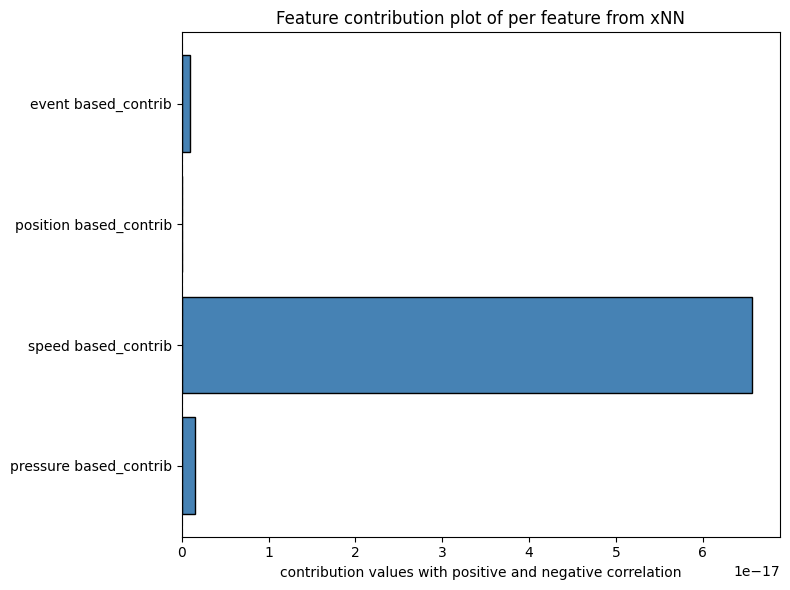

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

xnn_plot = xnn_contribution[['pressure based_contrib','speed based_contrib',
       'position based_contrib','event based_contrib']]

means_plot = xnn_plot.mean().fillna(0)
df_mean_plot = means_plot.to_frame(name="Mean Contribution")

fig, ax = plt.subplots(figsize=(8,6))
bars = ax.barh(
    df_mean_plot.index,
    df_mean_plot["Mean Contribution"],
    color="steelblue",    # ← same color for every bar
    edgecolor="black"
)

ax.axvline(0, color="black", linestyle="--", alpha=0.7)
ax.set_title("Feature contribution plot of per feature from xNN")
ax.set_xlabel("contribution values with positive and negative correlation")

plt.tight_layout()
plt.show()


### contribution plot of xNN per feature

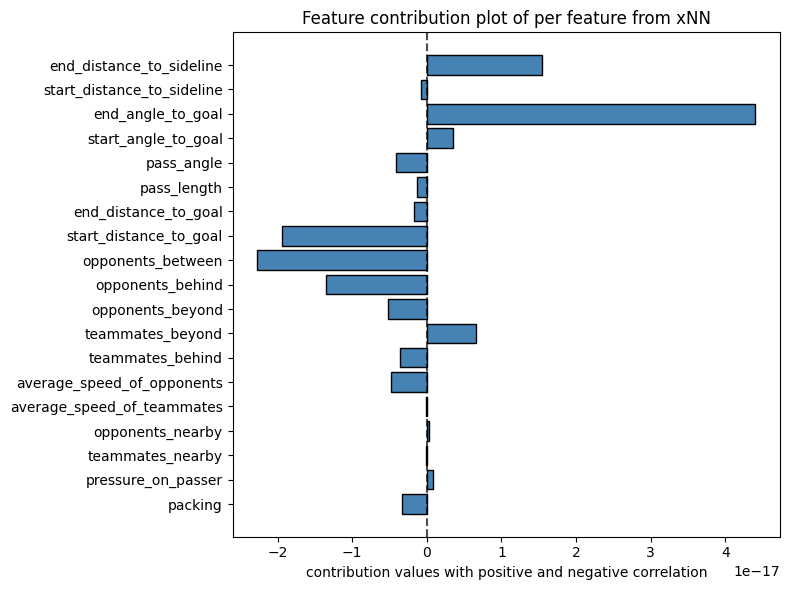

In [63]:
### have taken mean of features again just to plot
import matplotlib.pyplot as plt
import pandas as pd

df_plot = df_features_contrib.drop(['id'],axis=1)
means = df_plot.mean().fillna(0)
df_mean = means.to_frame(name="Mean Contribution")

fig, ax = plt.subplots(figsize=(8,6))
bars = ax.barh(
    df_mean.index,
    df_mean["Mean Contribution"],
    color="steelblue",    # ← same color for every bar
    edgecolor="black"
)

ax.axvline(0, color="black", linestyle="--", alpha=0.7)
ax.set_title("Feature contribution plot of per feature from xNN")
ax.set_xlabel("contribution values with positive and negative correlation")

plt.tight_layout()
plt.show()


In [86]:
df_params_model_1.to_csv("pressure_model_params.csv",index=False)

In [87]:
df_params_model_2.to_csv("speed_model_params.csv",index=False)

In [88]:
df_params_model_3.to_csv("position_model_params.csv",index=False)

In [89]:
df_params_model_4.to_csv("event_model_params.csv",index=False)

### plot of model contribution and per feature contribution for single pass

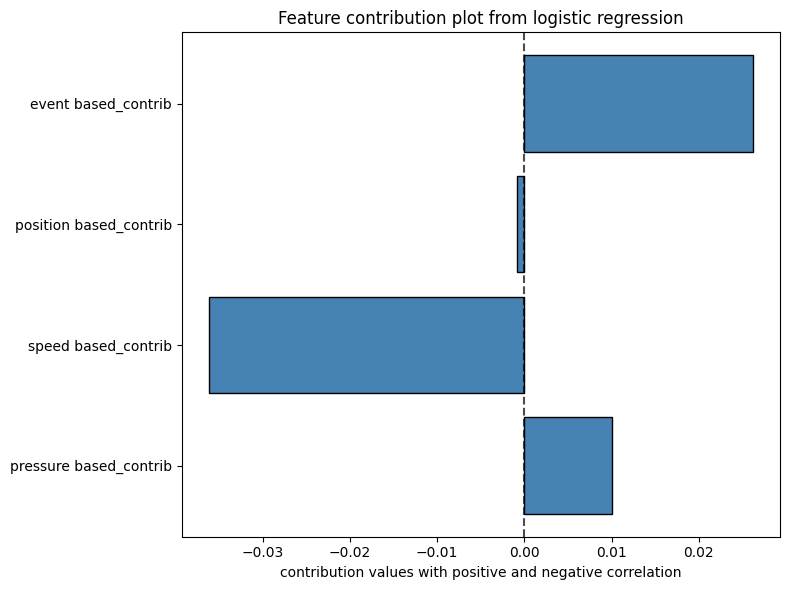

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

row = (
    xnn_df[xnn_df["id"] == 1442323882]
    .iloc[0]        
    .drop("id")
)
df_mean = row.to_frame(name="Mean Contribution")

fig, ax = plt.subplots(figsize=(8,6))
bars = ax.barh(
    df_mean.index,
    df_mean["Mean Contribution"],
    color="steelblue",    # ← same color for every bar
    edgecolor="black"
)

ax.axvline(0, color="black", linestyle="--", alpha=0.7)
ax.set_title("Feature contribution plot from logistic regression")
ax.set_xlabel("contribution values with positive and negative correlation")

plt.tight_layout()
plt.show()


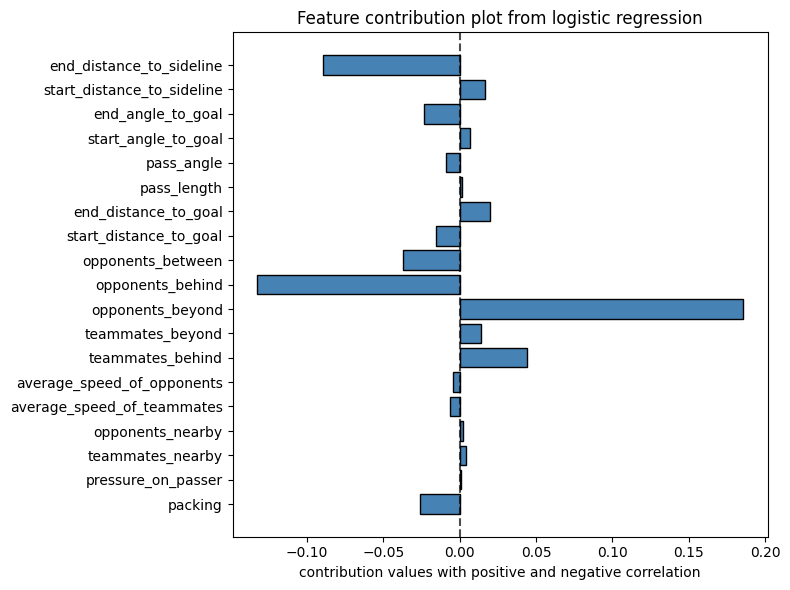

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

row = (contribution_features[contribution_features["id"] == 1442323882]
    .iloc[0]                  
    .drop("id")
)
df_mean = row.to_frame(name="Mean Contribution")

fig, ax = plt.subplots(figsize=(8,6))
bars = ax.barh(
    df_mean.index,
    df_mean["Mean Contribution"],
    color="steelblue",    # ← same color for every bar
    edgecolor="black"
)

ax.axvline(0, color="black", linestyle="--", alpha=0.7)
ax.set_title("Feature contribution plot from logistic regression")
ax.set_xlabel("contribution values with positive and negative correlation")

plt.tight_layout()
plt.show()
